#AMD vs non-AMD classification - 20% Image Scaling

##Mount Google Drive that contains training and test data sets.

In [0]:
# Seed value for random number generators to obtain reproducible results
RANDOM_SEED = 63

# Import packages into the namespace for this program
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
import datetime
import csv
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.utils import to_categorical, plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU

import cv2
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

## Comment out google drive mount after test files
## have already been produced for upload to Kaggle
from google.colab import drive
drive.mount('/content/gdrive')


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Define functions to load training and test images

In [0]:
def load_train_images(path):
    images = []
    labels = []
    widths = []
    heights = []

    # AMD labelled images
    print("\nAMD Images")
    folder = path + "AMD/"
    i = 0
    for filename in os.listdir(folder):
      if i % 50 == 0:
        print("Loading training image " + str(i))
        
        
      #if i == 20:
      #  break
        
        
      img = cv2.imread(os.path.join(folder, filename))
      if img is not None:
        images.append(img)
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        # label = 1 for AMD -- update the
        # labels list
        label = 1
        labels.append(label)
        img_flip = cv2.flip(img, 0)
        images.append(img_flip)
        labels.append(label)
        # Augment data by flipping each image on both axes
        both_axes_img = cv2.flip(img, -1)
        images.append(both_axes_img)
        labels.append(label)
      i+= 1

    # Non AMD labelled images
    print("\nNon-AMD Images")
    folder = path + "NonAMD/"
    j = 0
    for filename in os.listdir(folder):
      if j % 50 == 0:
        print("Loading training image " + str(j))
        
        
      #if j == 40:
      #  break
        
        
      img = cv2.imread(os.path.join(folder, filename))
      if img is not None:
        images.append(img)
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        # label =  for NonAMD -- update the
        # labels list
        label = 0
        labels.append(label)
      j+= 1

    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)

    print("\nAverage Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))
    
    #class_weight = {1:(float(i)/(i+j)), 0:(float(j)/(i+j))}

    return images, np.array(labels), avg_width, avg_height


def resize_train_images(images, width_resized, height_resized):
    images_resized = []

    # Resize
    i = 0
    for img in images:
      image_resized = cv2.resize(img, (width_resized, height_resized), interpolation=cv2.INTER_CUBIC)
      images_resized.append(image_resized)

      i+= 1

    return np.array(images_resized)



def load_test_images(folder):
    images = []
    i = 0
    for filename in os.listdir(folder):
      img = cv2.imread(os.path.join(folder, filename))
      if i % 500 == 0:
        print("Loading test image " + str(i))

      if img is not None:
        images.append(img)
      i+= 1

    return np.array(images)


def resize_test_images(images, width_resized, height_resized):
    images_resized = []
    images_resized_flat = []
    # Resize
    i = 0
    for img in images:
      image_resized = cv2.resize(img, (width_resized, height_resized), interpolation=cv2.INTER_CUBIC)
      images_resized.append(image_resized)

    return np.array(images_resized)


##Load training images and labels

In [0]:
path = "/content/gdrive/My Drive/"
images, labels, avg_width, avg_height = load_train_images(path)

images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=RANDOM_SEED)

# Reclaim memory for raw images and labels
del images, labels

# Convert labels to one-hot vector
y_train_one_hot = to_categorical(labels_train)
y_test_one_hot = to_categorical(labels_test)

# Determine class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(labels_train),
                                                  labels_train)
class_weight_dict = dict(enumerate(class_weights))
print("\nClass weights: " + str(class_weight_dict))


AMD Images
Loading training image 0
Loading training image 50

Non-AMD Images
Loading training image 0
Loading training image 50
Loading training image 100
Loading training image 150
Loading training image 200
Loading training image 250
Loading training image 300

Average Height: 1860.16
Max Height: 2056
Min Height: 1444


Average Width: 1906.4
Max Width: 2124
Min Width: 1444

Class weights: {0: 0.9130434782608695, 1: 1.105263157894737}



#Benchmark Testing Using Tensorflow and Keras


Instantiate lists of descriptive and performance statitics of the models

In [0]:
num_conv_layers_list = []
image_resize_percentage_list = []
processing_time_list = []
train_performance_list = []
test_performance_list = []
dropout_percentage_list = []
image_class_strength = {}

##25% Dropout Regularization

###5 Convolutional Layers; Image size: 20% of average original training image; 0.25 Dropout Regularization

####Train the model

In [0]:
# Resize training images to 20% original average width and height
width_resized = round(0.20 * avg_width)
height_resized = round(0.20 * avg_height)
train_images_20 = resize_train_images(images_train, width_resized, height_resized)
print("Training set with resized images shape: " + str(train_images_20.shape))


try:
  del images_train
except NameError:
  pass


Training set with resized images shape: (462, 372, 381, 3)


Define new model

In [0]:
# Network parameters
batch_size = 35


height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]
classes = 2

model = Sequential()

model.add(Conv2D(25, (3, 3), input_shape=(height, width, depth)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(100, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

##
model.add(Conv2D(150, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(200, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
##

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])

model.summary()


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=5),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("Final train accuracy = " +
      str(round(model.history.history["val_acc"][-1],5)))
print("Final loss = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")

processing_time_list.append(round(nn_time,2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 370, 379, 25)      700       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 370, 379, 25)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 370, 379, 25)      100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 126, 25)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 123, 126, 25)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 124, 50)      11300     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 121, 124, 50)      0         
__________

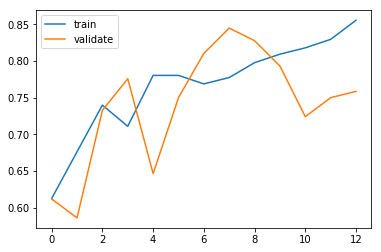

In [0]:
# Plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validate')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_5_20_20 = load_model('best_model.h5')

In [0]:
# Create train predictions
y_train_predict = np.argmax(saved_model_5_20_20.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print(str(np.around(saved_model_5_20_20.predict(train_images_20),decimals=3)))
print(str(y_train_predict))
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("score = " + str(score))
train_performance_list.append(score)

Shape of resized train images: (462, 372, 381, 3)
[[0.002 0.998]
 [0.998 0.002]
 [0.942 0.058]
 [0.591 0.409]
 [0.2   0.8  ]
 [0.023 0.977]
 [0.856 0.144]
 [0.322 0.678]
 [0.777 0.223]
 [0.787 0.213]
 [0.929 0.071]
 [0.812 0.188]
 [0.65  0.35 ]
 [0.74  0.26 ]
 [0.947 0.053]
 [0.995 0.005]
 [0.948 0.052]
 [0.649 0.351]
 [0.124 0.876]
 [0.089 0.911]
 [0.986 0.014]
 [0.163 0.837]
 [0.004 0.996]
 [0.969 0.031]
 [0.637 0.363]
 [0.994 0.006]
 [0.386 0.614]
 [0.997 0.003]
 [0.234 0.766]
 [0.854 0.146]
 [0.506 0.494]
 [0.005 0.995]
 [0.998 0.002]
 [0.708 0.292]
 [0.004 0.996]
 [0.966 0.034]
 [0.205 0.795]
 [0.037 0.963]
 [0.886 0.114]
 [0.024 0.976]
 [0.985 0.015]
 [0.528 0.472]
 [0.108 0.892]
 [0.906 0.094]
 [0.01  0.99 ]
 [0.403 0.597]
 [0.979 0.021]
 [0.007 0.993]
 [0.736 0.264]
 [0.655 0.345]
 [0.98  0.02 ]
 [0.994 0.006]
 [0.005 0.995]
 [0.939 0.061]
 [0.997 0.003]
 [0.873 0.127]
 [0.178 0.822]
 [0.008 0.992]
 [0.018 0.982]
 [0.    1.   ]
 [0.987 0.013]
 [0.128 0.872]
 [0.959 0.041]
 [0.0

####Test the model

In [0]:
width_resized = round(0.20 * avg_width)
height_resized = round(0.20 * avg_height)
test_images_20 = resize_test_images(images_test, width_resized, height_resized)
print("Shape of resized test images: " + str(test_images_20.shape))

"""
try:
  del images_test
except NameError:
  pass
"""

Shape of resized test images: (116, 372, 381, 3)


'\ntry:\n  del images_test\nexcept NameError:\n  pass\n'

In [0]:
# Create test predictions
y_test_predict = np.argmax(saved_model_5_20_20.predict(test_images_20), axis=1)
print(str(np.around(saved_model_5_20_20.predict(test_images_20),decimals=3)))
print(str(y_test_predict))
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("score = " + str(score))
test_performance_list.append(score)

## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/5_20_20.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label prediction - y_test_one_hot) are smallest
  image_class_strength[i] = abs(y_test_predict[i] - labels_test[i])
nn_out.close()

num_conv_layers_list.append(5)
image_resize_percentage_list.append(20)
dropout_percentage_list.append(25)

# Reclaim memory for model
try:
  del saved_model_5_20_20
except NameError:
  pass

[[0.925 0.075]
 [0.089 0.911]
 [0.837 0.163]
 [0.094 0.906]
 [0.361 0.639]
 [0.005 0.995]
 [0.978 0.022]
 [0.057 0.943]
 [0.989 0.011]
 [0.973 0.027]
 [0.367 0.633]
 [0.851 0.149]
 [0.972 0.028]
 [0.824 0.176]
 [0.154 0.846]
 [0.002 0.998]
 [0.151 0.849]
 [0.408 0.592]
 [0.054 0.946]
 [0.937 0.063]
 [0.005 0.995]
 [0.267 0.733]
 [0.942 0.058]
 [0.488 0.512]
 [0.991 0.009]
 [0.96  0.04 ]
 [0.924 0.076]
 [0.993 0.007]
 [0.805 0.195]
 [0.506 0.494]
 [0.941 0.059]
 [0.004 0.996]
 [0.106 0.894]
 [0.99  0.01 ]
 [0.949 0.051]
 [0.064 0.936]
 [0.018 0.982]
 [0.574 0.426]
 [0.523 0.477]
 [0.95  0.05 ]
 [0.366 0.634]
 [0.046 0.954]
 [0.174 0.826]
 [0.52  0.48 ]
 [0.992 0.008]
 [0.921 0.079]
 [0.994 0.006]
 [0.104 0.896]
 [0.221 0.779]
 [0.99  0.01 ]
 [0.87  0.13 ]
 [0.956 0.044]
 [0.014 0.986]
 [0.703 0.297]
 [0.044 0.956]
 [0.261 0.739]
 [1.    0.   ]
 [0.991 0.009]
 [0.993 0.007]
 [0.878 0.122]
 [0.003 0.997]
 [0.783 0.217]
 [0.904 0.096]
 [0.993 0.007]
 [0.029 0.971]
 [0.709 0.291]
 [0.016 0.

###4 Convolutional Layers; Image size: 20% of average original training image; 0.25 Dropout Regularization

####Train the model

Define new model

In [0]:
# Network parameters
batch_size = 35


height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]
classes = 2

model = Sequential()

model.add(Conv2D(25, (3, 3), input_shape=(height, width, depth)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(100, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

##
model.add(Conv2D(150, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
##

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])

model.summary()


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=5),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("Final train accuracy = " +
      str(round(model.history.history["val_acc"][-1],5)))
print("Final loss = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")

processing_time_list.append(round(nn_time,2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 370, 379, 25)      700       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 370, 379, 25)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 370, 379, 25)      100       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 123, 126, 25)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 123, 126, 25)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 121, 124, 50)      11300     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 121, 124, 50)      0         
__________

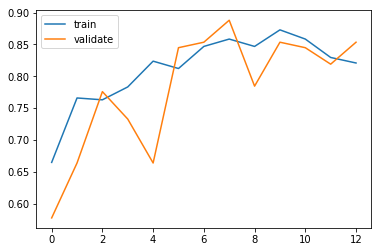

In [0]:
# Plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validate')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_4_20_20 = load_model('best_model.h5')

In [0]:
# Create train predictions
y_train_predict = np.argmax(saved_model_4_20_20.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print(str(np.around(saved_model_4_20_20.predict(train_images_20),decimals=3)))
print(str(y_train_predict))
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("score = " + str(score))
train_performance_list.append(score)

Shape of resized train images: (462, 372, 381, 3)
[[0.011 0.989]
 [0.999 0.001]
 [0.977 0.023]
 [0.459 0.541]
 [0.044 0.956]
 [0.007 0.993]
 [0.79  0.21 ]
 [0.03  0.97 ]
 [0.098 0.902]
 [0.593 0.407]
 [0.788 0.212]
 [0.999 0.001]
 [0.587 0.413]
 [0.541 0.459]
 [0.87  0.13 ]
 [0.999 0.001]
 [0.722 0.278]
 [0.585 0.415]
 [0.644 0.356]
 [0.418 0.582]
 [0.998 0.002]
 [0.047 0.953]
 [0.005 0.995]
 [0.991 0.009]
 [0.619 0.381]
 [1.    0.   ]
 [0.298 0.702]
 [0.999 0.001]
 [0.725 0.275]
 [0.055 0.945]
 [0.796 0.204]
 [0.005 0.995]
 [0.999 0.001]
 [0.852 0.148]
 [0.007 0.993]
 [0.942 0.058]
 [0.442 0.558]
 [0.363 0.637]
 [0.971 0.029]
 [0.099 0.901]
 [0.995 0.005]
 [0.721 0.279]
 [0.374 0.626]
 [0.979 0.021]
 [0.    1.   ]
 [0.913 0.087]
 [0.989 0.011]
 [0.055 0.945]
 [0.876 0.124]
 [0.627 0.373]
 [0.997 0.003]
 [0.998 0.002]
 [0.383 0.617]
 [0.968 0.032]
 [1.    0.   ]
 [0.994 0.006]
 [0.984 0.016]
 [0.035 0.965]
 [0.045 0.955]
 [0.    1.   ]
 [1.    0.   ]
 [0.173 0.827]
 [0.994 0.006]
 [0.0

####Test the model

In [0]:
# Create test predictions
y_test_predict = np.argmax(saved_model_4_20_20.predict(test_images_20), axis=1)
print(str(np.around(saved_model_4_20_20.predict(test_images_20),decimals=3)))
print(str(y_test_predict))
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("score = " + str(score))
test_performance_list.append(score)

## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/4_20_20.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label prediction - y_test_one_hot) are smallest
  image_class_strength[i]+= (abs(y_test_predict[i] - labels_test[i]))
nn_out.close()

num_conv_layers_list.append(4)
image_resize_percentage_list.append(20)
dropout_percentage_list.append(25)

# Reclaim memory for model
try:
  del saved_model_4_20_20
except NameError:
  pass

[[0.997 0.003]
 [0.004 0.996]
 [0.821 0.179]
 [0.677 0.323]
 [0.728 0.272]
 [0.003 0.997]
 [1.    0.   ]
 [0.004 0.996]
 [0.998 0.002]
 [0.985 0.015]
 [0.049 0.951]
 [0.814 0.186]
 [0.98  0.02 ]
 [0.826 0.174]
 [0.478 0.522]
 [0.    1.   ]
 [0.363 0.637]
 [0.186 0.814]
 [0.555 0.445]
 [0.97  0.03 ]
 [0.159 0.841]
 [0.194 0.806]
 [0.931 0.069]
 [0.567 0.433]
 [0.994 0.006]
 [0.984 0.016]
 [0.937 0.063]
 [1.    0.   ]
 [0.91  0.09 ]
 [0.238 0.762]
 [0.88  0.12 ]
 [0.014 0.986]
 [0.008 0.992]
 [0.998 0.002]
 [0.988 0.012]
 [0.003 0.997]
 [0.248 0.752]
 [0.683 0.317]
 [0.664 0.336]
 [0.897 0.103]
 [0.401 0.599]
 [0.007 0.993]
 [0.179 0.821]
 [0.988 0.012]
 [0.998 0.002]
 [0.523 0.477]
 [0.978 0.022]
 [0.116 0.884]
 [0.06  0.94 ]
 [0.998 0.002]
 [0.956 0.044]
 [0.993 0.007]
 [0.007 0.993]
 [0.954 0.046]
 [0.018 0.982]
 [0.797 0.203]
 [1.    0.   ]
 [1.    0.   ]
 [0.997 0.003]
 [0.63  0.37 ]
 [0.003 0.997]
 [0.906 0.094]
 [0.757 0.243]
 [0.999 0.001]
 [0.005 0.995]
 [0.802 0.198]
 [0.709 0.

###3 Convolutional Layers; Image size: 20% of average original training image; 0.25 Dropout Regularizatrion

####Train the model

Define new model

In [0]:
# Network parameters
batch_size = 35


height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]
classes = 2

model = Sequential()

model.add(Conv2D(25, (3, 3),  input_shape=(height, width, depth)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(100, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])

model.summary()


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=5),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("Final train accuracy = " +
      str(round(model.history.history["val_acc"][-1],5)))
print("Final loss = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")

processing_time_list.append(round(nn_time,2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 370, 379, 25)      700       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 370, 379, 25)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 370, 379, 25)      100       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 123, 126, 25)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 123, 126, 25)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 121, 124, 50)      11300     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 121, 124, 50)      0         
__________

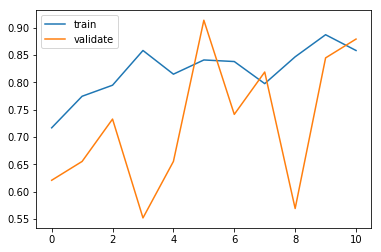

In [0]:
# Plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validate')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_3_20_20 = load_model('best_model.h5')

In [0]:
# Create train predictions
y_train_predict = np.argmax(saved_model_3_20_20.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print(str(np.around(saved_model_3_20_20.predict(train_images_20),decimals=3)))
print(str(y_train_predict))
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("score = " + str(score))
train_performance_list.append(score)

Shape of resized train images: (462, 372, 381, 3)
[[0.002 0.998]
 [1.    0.   ]
 [0.814 0.186]
 [0.311 0.689]
 [0.072 0.928]
 [0.005 0.995]
 [0.814 0.186]
 [0.275 0.725]
 [0.269 0.731]
 [0.847 0.153]
 [0.599 0.401]
 [0.995 0.005]
 [0.472 0.528]
 [0.174 0.826]
 [0.932 0.068]
 [0.994 0.006]
 [0.913 0.087]
 [0.171 0.829]
 [0.11  0.89 ]
 [0.36  0.64 ]
 [0.977 0.023]
 [0.025 0.975]
 [0.006 0.994]
 [0.916 0.084]
 [0.182 0.818]
 [0.998 0.002]
 [0.082 0.918]
 [0.998 0.002]
 [0.769 0.231]
 [0.524 0.476]
 [0.681 0.319]
 [0.023 0.977]
 [0.991 0.009]
 [0.436 0.564]
 [0.022 0.978]
 [0.667 0.333]
 [0.85  0.15 ]
 [0.008 0.992]
 [0.952 0.048]
 [0.011 0.989]
 [0.896 0.104]
 [0.414 0.586]
 [0.384 0.616]
 [0.919 0.081]
 [0.001 0.999]
 [0.83  0.17 ]
 [0.993 0.007]
 [0.078 0.922]
 [0.85  0.15 ]
 [0.482 0.518]
 [0.96  0.04 ]
 [0.993 0.007]
 [0.34  0.66 ]
 [0.822 0.178]
 [0.999 0.001]
 [0.905 0.095]
 [0.931 0.069]
 [0.007 0.993]
 [0.015 0.985]
 [0.    1.   ]
 [0.997 0.003]
 [0.151 0.849]
 [0.975 0.025]
 [0.0

####Test the model

In [0]:
# Create test predictions
y_test_predict = np.argmax(saved_model_3_20_20.predict(test_images_20), axis=1)
print(str(np.around(saved_model_3_20_20.predict(test_images_20),decimals=3)))
print(str(y_test_predict))
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("score = " + str(score))
test_performance_list.append(score)

## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/3_20_20.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label prediction - y_test_one_hot) are smallest
  image_class_strength[i]+= abs(y_test_predict[i] - labels_test[i])
nn_out.close()

num_conv_layers_list.append(3)
image_resize_percentage_list.append(20)
dropout_percentage_list.append(25)

# Reclaim memory for model
try:
  del saved_model_3_20_20
except NameError:
  pass

[[0.998 0.002]
 [0.01  0.99 ]
 [0.655 0.345]
 [0.871 0.129]
 [0.242 0.758]
 [0.005 0.995]
 [0.993 0.007]
 [0.004 0.996]
 [0.996 0.004]
 [0.963 0.037]
 [0.124 0.876]
 [0.466 0.534]
 [0.964 0.036]
 [0.376 0.624]
 [0.294 0.706]
 [0.003 0.997]
 [0.637 0.363]
 [0.061 0.939]
 [0.124 0.876]
 [0.941 0.059]
 [0.049 0.951]
 [0.104 0.896]
 [0.947 0.053]
 [0.332 0.668]
 [0.978 0.022]
 [0.885 0.115]
 [0.831 0.169]
 [0.996 0.004]
 [0.958 0.042]
 [0.111 0.889]
 [0.918 0.082]
 [0.009 0.991]
 [0.003 0.997]
 [0.974 0.026]
 [0.897 0.103]
 [0.003 0.997]
 [0.002 0.998]
 [0.505 0.495]
 [0.831 0.169]
 [0.969 0.031]
 [0.371 0.629]
 [0.016 0.984]
 [0.067 0.933]
 [0.903 0.097]
 [0.994 0.006]
 [0.235 0.765]
 [0.887 0.113]
 [0.036 0.964]
 [0.011 0.989]
 [0.971 0.029]
 [0.676 0.324]
 [0.933 0.067]
 [0.002 0.998]
 [0.843 0.157]
 [0.006 0.994]
 [0.422 0.578]
 [1.    0.   ]
 [0.999 0.001]
 [0.988 0.012]
 [0.602 0.398]
 [0.025 0.975]
 [0.805 0.195]
 [0.143 0.857]
 [0.98  0.02 ]
 [0.013 0.987]
 [0.764 0.236]
 [0.534 0.

###2 Convolutional Layers; Image size: 20% of average original training image; 0.25 Dropout Regularizatrion

####Train the model

Define new model

In [0]:
# Network parameters
batch_size = 35


height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]
classes = 2

model = Sequential()

model.add(Conv2D(25, (3, 3),  input_shape=(height, width, depth)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])

model.summary()


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=5),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("Final train accuracy = " +
      str(round(model.history.history["val_acc"][-1],5)))
print("Final loss = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")

processing_time_list.append(round(nn_time,2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 370, 379, 25)      700       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 370, 379, 25)      0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 370, 379, 25)      100       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 123, 126, 25)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 123, 126, 25)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 121, 124, 50)      11300     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 121, 124, 50)      0         
__________

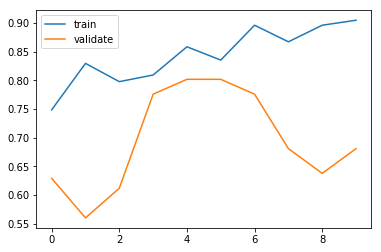

In [0]:
# Plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validate')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_2_20_20 = load_model('best_model.h5')

In [0]:
# Create train predictions
y_train_predict = np.argmax(saved_model_2_20_20.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print(str(np.around(saved_model_2_20_20.predict(train_images_20),decimals=3)))
print(str(y_train_predict))
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("score = " + str(score))
train_performance_list.append(score)

Shape of resized train images: (462, 372, 381, 3)
[[0.032 0.968]
 [1.    0.   ]
 [0.914 0.086]
 [0.697 0.303]
 [0.715 0.285]
 [0.286 0.714]
 [0.895 0.105]
 [0.777 0.223]
 [0.85  0.15 ]
 [0.994 0.006]
 [0.831 0.169]
 [0.992 0.008]
 [0.943 0.057]
 [0.586 0.414]
 [0.962 0.038]
 [1.    0.   ]
 [0.96  0.04 ]
 [0.54  0.46 ]
 [0.855 0.145]
 [0.948 0.052]
 [1.    0.   ]
 [0.247 0.753]
 [0.101 0.899]
 [1.    0.   ]
 [0.887 0.113]
 [0.992 0.008]
 [0.483 0.517]
 [0.999 0.001]
 [0.636 0.364]
 [0.259 0.741]
 [1.    0.   ]
 [0.102 0.898]
 [0.998 0.002]
 [0.993 0.007]
 [0.178 0.822]
 [0.991 0.009]
 [0.313 0.687]
 [0.053 0.947]
 [0.95  0.05 ]
 [0.216 0.784]
 [1.    0.   ]
 [0.928 0.072]
 [0.212 0.788]
 [0.996 0.004]
 [0.907 0.093]
 [0.994 0.006]
 [1.    0.   ]
 [0.599 0.401]
 [0.982 0.018]
 [0.946 0.054]
 [1.    0.   ]
 [0.98  0.02 ]
 [0.087 0.913]
 [0.999 0.001]
 [1.    0.   ]
 [0.924 0.076]
 [0.999 0.001]
 [0.039 0.961]
 [0.52  0.48 ]
 [0.005 0.995]
 [0.993 0.007]
 [0.633 0.367]
 [0.986 0.014]
 [0.3

####Test the model

In [0]:
# Create test predictions
y_test_predict = np.argmax(saved_model_2_20_20.predict(test_images_20), axis=1)
print(str(np.around(saved_model_2_20_20.predict(test_images_20),decimals=3)))
print(str(y_test_predict))
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("score = " + str(score))
test_performance_list.append(score)

## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/2_20_20.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label prediction - y_test_one_hot) are smallest
  image_class_strength[i]+= abs(y_test_predict[i] - labels_test[i])
nn_out.close()

num_conv_layers_list.append(2)
image_resize_percentage_list.append(20)
dropout_percentage_list.append(25)

# Reclaim memory for model
try:
  del saved_model_2_20_20
except NameError:
  pass

[[1.    0.   ]
 [0.218 0.782]
 [0.961 0.039]
 [0.351 0.649]
 [0.633 0.367]
 [0.664 0.336]
 [0.989 0.011]
 [0.035 0.965]
 [1.    0.   ]
 [0.999 0.001]
 [0.472 0.528]
 [0.956 0.044]
 [0.987 0.013]
 [0.889 0.111]
 [0.776 0.224]
 [0.045 0.955]
 [0.821 0.179]
 [0.999 0.001]
 [0.822 0.178]
 [0.6   0.4  ]
 [0.066 0.934]
 [0.969 0.031]
 [0.844 0.156]
 [0.301 0.699]
 [0.974 0.026]
 [0.99  0.01 ]
 [1.    0.   ]
 [1.    0.   ]
 [0.956 0.044]
 [0.458 0.542]
 [0.961 0.039]
 [0.017 0.983]
 [0.029 0.971]
 [1.    0.   ]
 [0.986 0.014]
 [0.32  0.68 ]
 [0.173 0.827]
 [0.112 0.888]
 [0.945 0.055]
 [0.978 0.022]
 [0.981 0.019]
 [0.988 0.012]
 [0.521 0.479]
 [0.986 0.014]
 [1.    0.   ]
 [0.866 0.134]
 [0.961 0.039]
 [0.127 0.873]
 [0.032 0.968]
 [1.    0.   ]
 [0.671 0.329]
 [1.    0.   ]
 [0.009 0.991]
 [0.96  0.04 ]
 [0.155 0.845]
 [0.851 0.149]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.977 0.023]
 [0.171 0.829]
 [0.963 0.037]
 [0.949 0.051]
 [0.832 0.168]
 [0.017 0.983]
 [0.968 0.032]
 [0.197 0.

###5 Convolutional Layers; Image size: 20% of average original training image; 0.45 Dropout Regularization

####Train the model

Define new model

In [0]:
# Network parameters
batch_size = 35


height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]
classes = 2

model = Sequential()

model.add(Conv2D(25, (3, 3), input_shape=(height, width, depth)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Conv2D(100, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

##
model.add(Conv2D(150, (2, 2)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

model.add(Conv2D(200, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))
##

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])

model.summary()


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=5),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("Final train accuracy = " +
      str(round(model.history.history["val_acc"][-1],5)))
print("Final loss = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")

processing_time_list.append(round(nn_time,2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 370, 379, 25)      700       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 370, 379, 25)      0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 370, 379, 25)      100       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 123, 126, 25)      0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 123, 126, 25)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 121, 124, 50)      11300     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 121, 124, 50)      0         
__________

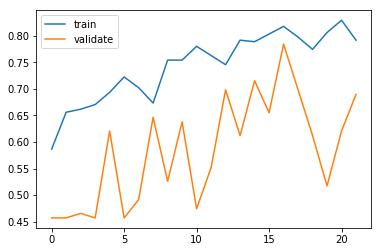

In [0]:
# Plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validate')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_5_20_45 = load_model('best_model.h5')

In [0]:
# Create train predictions
y_train_predict = np.argmax(saved_model_5_20_45.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print(str(np.around(saved_model_5_20_45.predict(train_images_20),decimals=3)))
print(str(y_train_predict))
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("score = " + str(score))
train_performance_list.append(score)

Shape of resized train images: (462, 372, 381, 3)
[[0.027 0.973]
 [0.975 0.025]
 [0.734 0.266]
 [0.406 0.594]
 [0.392 0.608]
 [0.142 0.858]
 [0.645 0.355]
 [0.404 0.596]
 [0.732 0.268]
 [0.591 0.409]
 [0.805 0.195]
 [0.28  0.72 ]
 [0.403 0.597]
 [0.315 0.685]
 [0.727 0.273]
 [0.962 0.038]
 [0.781 0.219]
 [0.663 0.337]
 [0.167 0.833]
 [0.416 0.584]
 [0.902 0.098]
 [0.206 0.794]
 [0.027 0.973]
 [0.73  0.27 ]
 [0.392 0.608]
 [0.86  0.14 ]
 [0.2   0.8  ]
 [0.944 0.056]
 [0.429 0.571]
 [0.764 0.236]
 [0.672 0.328]
 [0.059 0.941]
 [0.87  0.13 ]
 [0.459 0.541]
 [0.045 0.955]
 [0.7   0.3  ]
 [0.211 0.789]
 [0.085 0.915]
 [0.52  0.48 ]
 [0.051 0.949]
 [0.887 0.113]
 [0.4   0.6  ]
 [0.172 0.828]
 [0.628 0.372]
 [0.135 0.865]
 [0.25  0.75 ]
 [0.946 0.054]
 [0.075 0.925]
 [0.781 0.219]
 [0.481 0.519]
 [0.846 0.154]
 [0.833 0.167]
 [0.015 0.985]
 [0.755 0.245]
 [0.835 0.165]
 [0.434 0.566]
 [0.344 0.656]
 [0.152 0.848]
 [0.123 0.877]
 [0.015 0.985]
 [0.703 0.297]
 [0.193 0.807]
 [0.588 0.412]
 [0.1

####Test the model

In [0]:
# Create test predictions
y_test_predict = np.argmax(saved_model_5_20_45.predict(test_images_20), axis=1)
print(str(np.around(saved_model_5_20_45.predict(test_images_20),decimals=3)))
print(str(y_test_predict))
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("score = " + str(score))
test_performance_list.append(score)

## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/5_20_45.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label prediction - y_test_one_hot) are smallest
  image_class_strength[i]+= abs(y_test_predict[i] - labels_test[i])
nn_out.close()

num_conv_layers_list.append(5)
image_resize_percentage_list.append(20)
dropout_percentage_list.append(45)

# Reclaim memory for model
try:
  del saved_model_5_20_45
except NameError:
  pass

[[0.109 0.891]
 [0.042 0.958]
 [0.725 0.275]
 [0.152 0.848]
 [0.173 0.827]
 [0.175 0.825]
 [0.521 0.479]
 [0.073 0.927]
 [0.924 0.076]
 [0.819 0.181]
 [0.451 0.549]
 [0.591 0.409]
 [0.669 0.331]
 [0.7   0.3  ]
 [0.388 0.612]
 [0.017 0.983]
 [0.291 0.709]
 [0.514 0.486]
 [0.292 0.708]
 [0.609 0.391]
 [0.014 0.986]
 [0.384 0.616]
 [0.581 0.419]
 [0.213 0.787]
 [0.82  0.18 ]
 [0.707 0.293]
 [0.809 0.191]
 [0.942 0.058]
 [0.259 0.741]
 [0.403 0.597]
 [0.681 0.319]
 [0.033 0.967]
 [0.072 0.928]
 [0.917 0.083]
 [0.664 0.336]
 [0.168 0.832]
 [0.056 0.944]
 [0.346 0.654]
 [0.561 0.439]
 [0.739 0.261]
 [0.502 0.498]
 [0.415 0.585]
 [0.169 0.831]
 [0.331 0.669]
 [0.883 0.117]
 [0.624 0.376]
 [0.925 0.075]
 [0.057 0.943]
 [0.073 0.927]
 [0.928 0.072]
 [0.488 0.512]
 [0.838 0.162]
 [0.048 0.952]
 [0.453 0.547]
 [0.148 0.852]
 [0.281 0.719]
 [0.98  0.02 ]
 [0.913 0.087]
 [0.928 0.072]
 [0.554 0.446]
 [0.053 0.947]
 [0.56  0.44 ]
 [0.788 0.212]
 [0.777 0.223]
 [0.081 0.919]
 [0.648 0.352]
 [0.236 0.

###4 Convolutional Layers; Image size: 20% of average original training image; 0.45 Dropout Regularization

####Train the model

Define new model

In [0]:
# Network parameters
batch_size = 35


height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]
classes = 2

model = Sequential()

model.add(Conv2D(25, (3, 3), input_shape=(height, width, depth)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Conv2D(100, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

##
model.add(Conv2D(150, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))
##

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])

model.summary()


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=5),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("Final train accuracy = " +
      str(round(model.history.history["val_acc"][-1],5)))
print("Final loss = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")

processing_time_list.append(round(nn_time,2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 370, 379, 25)      700       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 370, 379, 25)      0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 370, 379, 25)      100       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 123, 126, 25)      0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 123, 126, 25)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 121, 124, 50)      11300     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 121, 124, 50)      0         
__________

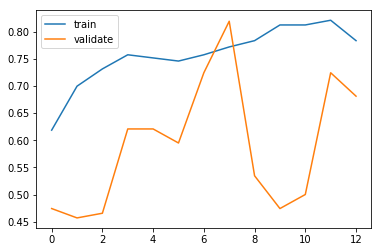

In [0]:
# Plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validate')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_4_20_45 = load_model('best_model.h5')

In [0]:
# Create train predictions
y_train_predict = np.argmax(saved_model_4_20_45.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print(str(np.around(saved_model_4_20_45.predict(train_images_20),decimals=3)))
print(str(y_train_predict))
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("score = " + str(score))
train_performance_list.append(score)

Shape of resized train images: (462, 372, 381, 3)
[[0.043 0.957]
 [0.978 0.022]
 [0.981 0.019]
 [0.752 0.248]
 [0.101 0.899]
 [0.013 0.987]
 [0.973 0.027]
 [0.284 0.716]
 [0.907 0.093]
 [0.862 0.138]
 [0.973 0.027]
 [0.981 0.019]
 [0.821 0.179]
 [0.5   0.5  ]
 [0.983 0.017]
 [0.977 0.023]
 [0.99  0.01 ]
 [0.907 0.093]
 [0.342 0.658]
 [0.263 0.737]
 [0.834 0.166]
 [0.195 0.805]
 [0.033 0.967]
 [0.868 0.132]
 [0.83  0.17 ]
 [0.987 0.013]
 [0.471 0.529]
 [0.999 0.001]
 [0.88  0.12 ]
 [0.97  0.03 ]
 [0.583 0.417]
 [0.027 0.973]
 [0.999 0.001]
 [0.484 0.516]
 [0.025 0.975]
 [0.871 0.129]
 [0.898 0.102]
 [0.417 0.583]
 [0.987 0.013]
 [0.238 0.762]
 [0.683 0.317]
 [0.373 0.627]
 [0.627 0.373]
 [0.708 0.292]
 [0.027 0.973]
 [0.381 0.619]
 [0.978 0.022]
 [0.037 0.963]
 [0.903 0.097]
 [0.811 0.189]
 [0.947 0.053]
 [0.999 0.001]
 [0.206 0.794]
 [0.65  0.35 ]
 [0.993 0.007]
 [0.952 0.048]
 [0.477 0.523]
 [0.492 0.508]
 [0.027 0.973]
 [0.015 0.985]
 [0.998 0.002]
 [0.156 0.844]
 [0.968 0.032]
 [0.0

####Test the model

In [0]:
# Create test predictions
y_test_predict = np.argmax(saved_model_4_20_45.predict(test_images_20), axis=1)
print(str(np.around(saved_model_4_20_45.predict(test_images_20),decimals=3)))
print(str(y_test_predict))
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("score = " + str(score))
test_performance_list.append(score)

## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/4_20_45.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label prediction - y_test_one_hot) are smallest
  image_class_strength[i]+= abs(y_test_predict[i] - labels_test[i])
nn_out.close()

num_conv_layers_list.append(4)
image_resize_percentage_list.append(20)
dropout_percentage_list.append(45)

# Reclaim memory for model
try:
  del saved_model_4_20_45
except NameError:
  pass

[[0.584 0.416]
 [0.5   0.5  ]
 [0.949 0.051]
 [0.607 0.393]
 [0.555 0.445]
 [0.044 0.956]
 [0.99  0.01 ]
 [0.393 0.607]
 [0.786 0.214]
 [0.974 0.026]
 [0.761 0.239]
 [0.514 0.486]
 [0.989 0.011]
 [0.667 0.333]
 [0.499 0.501]
 [0.011 0.989]
 [0.27  0.73 ]
 [0.446 0.554]
 [0.472 0.528]
 [0.994 0.006]
 [0.035 0.965]
 [0.25  0.75 ]
 [0.977 0.023]
 [0.872 0.128]
 [0.998 0.002]
 [0.944 0.056]
 [0.724 0.276]
 [0.733 0.267]
 [0.967 0.033]
 [0.755 0.245]
 [0.951 0.049]
 [0.033 0.967]
 [0.062 0.938]
 [0.939 0.061]
 [0.966 0.034]
 [0.198 0.802]
 [0.238 0.762]
 [0.831 0.169]
 [0.909 0.091]
 [0.978 0.022]
 [0.222 0.778]
 [0.086 0.914]
 [0.36  0.64 ]
 [0.809 0.191]
 [0.988 0.012]
 [0.742 0.258]
 [0.998 0.002]
 [0.12  0.88 ]
 [0.334 0.666]
 [0.911 0.089]
 [0.981 0.019]
 [0.961 0.039]
 [0.088 0.912]
 [0.96  0.04 ]
 [0.132 0.868]
 [0.829 0.171]
 [1.    0.   ]
 [0.986 0.014]
 [0.917 0.083]
 [0.752 0.248]
 [0.008 0.992]
 [0.935 0.065]
 [0.993 0.007]
 [0.999 0.001]
 [0.055 0.945]
 [0.657 0.343]
 [0.682 0.

###3 Convolutional Layers; Image size: 20% of average original training image; 0.45 Dropout Regularizatrion

####Train the model

Define new model

In [0]:
# Network parameters
batch_size = 35


height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]
classes = 2

model = Sequential()

model.add(Conv2D(25, (3, 3),  input_shape=(height, width, depth)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Conv2D(100, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])

model.summary()


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=5),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("Final train accuracy = " +
      str(round(model.history.history["val_acc"][-1],5)))
print("Final loss = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")

processing_time_list.append(round(nn_time,2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 370, 379, 25)      700       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 370, 379, 25)      0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 370, 379, 25)      100       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 123, 126, 25)      0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 123, 126, 25)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 121, 124, 50)      11300     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 121, 124, 50)      0         
__________

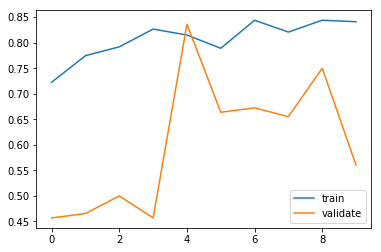

In [0]:
# Plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validate')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_3_20_45 = load_model('best_model.h5')

In [0]:
# Create train predictions
y_train_predict = np.argmax(saved_model_3_20_45.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print(str(np.around(saved_model_3_20_45.predict(train_images_20),decimals=3)))
print(str(y_train_predict))
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("score = " + str(score))
train_performance_list.append(score)

Shape of resized train images: (462, 372, 381, 3)
[[0.007 0.993]
 [0.995 0.005]
 [0.675 0.325]
 [0.487 0.513]
 [0.03  0.97 ]
 [0.005 0.995]
 [0.738 0.262]
 [0.524 0.476]
 [0.086 0.914]
 [0.691 0.309]
 [0.256 0.744]
 [0.922 0.078]
 [0.81  0.19 ]
 [0.425 0.575]
 [0.958 0.042]
 [0.776 0.224]
 [0.735 0.265]
 [0.155 0.845]
 [0.118 0.882]
 [0.078 0.922]
 [0.99  0.01 ]
 [0.04  0.96 ]
 [0.004 0.996]
 [0.932 0.068]
 [0.341 0.659]
 [0.675 0.325]
 [0.624 0.376]
 [0.704 0.296]
 [0.47  0.53 ]
 [0.03  0.97 ]
 [0.392 0.608]
 [0.018 0.982]
 [0.606 0.394]
 [0.717 0.283]
 [0.009 0.991]
 [0.951 0.049]
 [0.234 0.766]
 [0.019 0.981]
 [0.879 0.121]
 [0.107 0.893]
 [0.978 0.022]
 [0.464 0.536]
 [0.012 0.988]
 [0.903 0.097]
 [0.001 0.999]
 [0.239 0.761]
 [0.831 0.169]
 [0.044 0.956]
 [0.274 0.726]
 [0.579 0.421]
 [0.974 0.026]
 [0.725 0.275]
 [0.008 0.992]
 [0.852 0.148]
 [0.386 0.614]
 [0.778 0.222]
 [0.383 0.617]
 [0.    1.   ]
 [0.005 0.995]
 [0.002 0.998]
 [0.966 0.034]
 [0.037 0.963]
 [0.451 0.549]
 [0.0

####Test the model

In [0]:
# Create test predictions
y_test_predict = np.argmax(saved_model_3_20_45.predict(test_images_20), axis=1)
print(str(np.around(saved_model_3_20_45.predict(test_images_20),decimals=3)))
print(str(y_test_predict))
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("score = " + str(score))
test_performance_list.append(score)

## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/3_20_45.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label prediction - y_test_one_hot) are smallest
  image_class_strength[i]+= abs(y_test_predict[i] - labels_test[i])
nn_out.close()

num_conv_layers_list.append(3)
image_resize_percentage_list.append(20)
dropout_percentage_list.append(45)

# Reclaim memory for model
try:
  del saved_model_3_20_45
except NameError:
  pass

[[0.979 0.021]
 [0.037 0.963]
 [0.864 0.136]
 [0.145 0.855]
 [0.627 0.373]
 [0.001 0.999]
 [0.926 0.074]
 [0.048 0.952]
 [0.989 0.011]
 [0.957 0.043]
 [0.052 0.948]
 [0.704 0.296]
 [0.969 0.031]
 [0.56  0.44 ]
 [0.185 0.815]
 [0.002 0.998]
 [0.162 0.838]
 [0.507 0.493]
 [0.219 0.781]
 [0.572 0.428]
 [0.004 0.996]
 [0.142 0.858]
 [0.947 0.053]
 [0.356 0.644]
 [0.482 0.518]
 [0.955 0.045]
 [0.837 0.163]
 [0.997 0.003]
 [0.867 0.133]
 [0.024 0.976]
 [0.804 0.196]
 [0.007 0.993]
 [0.019 0.981]
 [0.99  0.01 ]
 [0.974 0.026]
 [0.01  0.99 ]
 [0.012 0.988]
 [0.364 0.636]
 [0.377 0.623]
 [0.824 0.176]
 [0.29  0.71 ]
 [0.011 0.989]
 [0.178 0.822]
 [0.923 0.077]
 [0.989 0.011]
 [0.633 0.367]
 [0.788 0.212]
 [0.04  0.96 ]
 [0.066 0.934]
 [0.993 0.007]
 [0.73  0.27 ]
 [0.098 0.902]
 [0.016 0.984]
 [0.856 0.144]
 [0.013 0.987]
 [0.534 0.466]
 [0.974 0.026]
 [0.996 0.004]
 [0.979 0.021]
 [0.634 0.366]
 [0.009 0.991]
 [0.697 0.303]
 [0.188 0.812]
 [0.796 0.204]
 [0.002 0.998]
 [0.836 0.164]
 [0.001 0.

###2 Convolutional Layers; Image size: 20% of average original training image; 0.45 Dropout Regularizatrion

####Train the model

Define new model

In [0]:
# Network parameters
batch_size = 35


height = train_images_20.shape[1]
width = train_images_20.shape[2]
depth = train_images_20.shape[3]
classes = 2

model = Sequential()

model.add(Conv2D(25, (3, 3), input_shape=(height, width, depth)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['accuracy'])

model.summary()


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=5),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_acc', mode='max',
                             save_best_only=True)]


# Record the time needed to train the network
start = datetime.datetime.now()

# Train neural network
history = model.fit(train_images_20, # Features
                      y_train_one_hot, # Target vector
                      epochs=40, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      shuffle=True,
                      class_weight=class_weight_dict,
                      verbose=1, # Print description after each epoch
                      batch_size=batch_size, # Number of observations per batch
                      validation_split=0.25) # Data for evaluation


print("Final train accuracy = " +
      str(round(model.history.history["val_acc"][-1],5)))
print("Final loss = " +
      str(round(model.history.history["loss"][-1],5)))

# Display and save the time needed to train the network
end = datetime.datetime.now()
nn_time = (end - start).total_seconds()
print("Elapsed time to train Neural Network Classification:\n" +
      "   " + str(round(nn_time,2)) + " seconds\n")

processing_time_list.append(round(nn_time,2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 370, 379, 25)      700       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 370, 379, 25)      0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 370, 379, 25)      100       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 123, 126, 25)      0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 123, 126, 25)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 121, 124, 50)      11300     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 121, 124, 50)      0         
__________

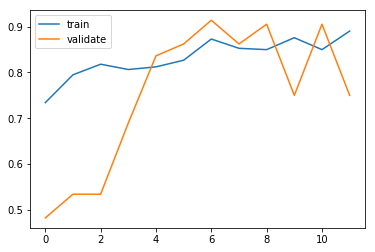

In [0]:
# Plot training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validate')
plt.legend()
plt.show()

In [0]:
# Save best model
saved_model_2_20_45 = load_model('best_model.h5')

In [0]:
# Create train predictions
y_train_predict = np.argmax(saved_model_2_20_45.predict(train_images_20), axis=1)
print("Shape of resized train images: " + str(train_images_20.shape))
print(str(np.around(saved_model_2_20_45.predict(train_images_20),decimals=3)))
print(str(y_train_predict))
print(str(labels_train))

score = accuracy_score(labels_train, y_train_predict, normalize=True)
print("score = " + str(score))
train_performance_list.append(score)

Shape of resized train images: (462, 372, 381, 3)
[[0.009 0.991]
 [1.    0.   ]
 [0.887 0.113]
 [0.519 0.481]
 [0.029 0.971]
 [0.004 0.996]
 [0.77  0.23 ]
 [0.455 0.545]
 [0.075 0.925]
 [0.737 0.263]
 [0.717 0.283]
 [0.962 0.038]
 [0.748 0.252]
 [0.431 0.569]
 [0.878 0.122]
 [0.962 0.038]
 [0.757 0.243]
 [0.225 0.775]
 [0.045 0.955]
 [0.112 0.888]
 [0.999 0.001]
 [0.085 0.915]
 [0.007 0.993]
 [0.934 0.066]
 [0.718 0.282]
 [0.99  0.01 ]
 [0.301 0.699]
 [0.976 0.024]
 [0.591 0.409]
 [0.146 0.854]
 [0.485 0.515]
 [0.052 0.948]
 [0.963 0.037]
 [0.464 0.536]
 [0.037 0.963]
 [0.953 0.047]
 [0.732 0.268]
 [0.045 0.955]
 [0.941 0.059]
 [0.081 0.919]
 [0.994 0.006]
 [0.521 0.479]
 [0.069 0.931]
 [0.933 0.067]
 [0.073 0.927]
 [0.46  0.54 ]
 [0.926 0.074]
 [0.078 0.922]
 [0.726 0.274]
 [0.672 0.328]
 [0.984 0.016]
 [0.961 0.039]
 [0.065 0.935]
 [0.911 0.089]
 [0.905 0.095]
 [0.731 0.269]
 [0.802 0.198]
 [0.025 0.975]
 [0.009 0.991]
 [0.008 0.992]
 [0.992 0.008]
 [0.172 0.828]
 [0.93  0.07 ]
 [0.0

####Test the model

In [0]:
# Create test predictions
y_test_predict = np.argmax(saved_model_2_20_45.predict(test_images_20), axis=1)
print(str(np.around(saved_model_2_20_45.predict(test_images_20),decimals=3)))
print(str(y_test_predict))
print(str(labels_test))

score = accuracy_score(labels_test, y_test_predict, normalize=True)
print("score = " + str(score))
test_performance_list.append(score)

## Open new csv file on Google drive
nn_out = open("/content/gdrive/My Drive/2_20_45.csv", "wt")
csv_writer = csv.writer(nn_out, delimiter=',', quotechar='"')
## Write headers
csv_writer.writerow(['id','label'])
#
## Write each prediction to separate row
## Each row consists of Image ID and label prediction, comma separated
for i in range(y_test_predict.shape[0]):
  csv_writer.writerow([str(i+1), str(y_test_predict[i])])
  # Find images most strongly classified, those for which
  # abs(label prediction - y_test_one_hot) are smallest
  image_class_strength[i]+= abs(y_test_predict[i] - labels_test[i])
nn_out.close()

num_conv_layers_list.append(2)
image_resize_percentage_list.append(20)
dropout_percentage_list.append(45)

# Reclaim memory for model
try:
  del saved_model_2_20_45
except NameError:
  pass

[[0.991 0.009]
 [0.088 0.912]
 [0.8   0.2  ]
 [0.515 0.485]
 [0.567 0.433]
 [0.009 0.991]
 [0.987 0.013]
 [0.12  0.88 ]
 [0.998 0.002]
 [0.968 0.032]
 [0.269 0.731]
 [0.552 0.448]
 [0.965 0.035]
 [0.254 0.746]
 [0.314 0.686]
 [0.015 0.985]
 [0.262 0.738]
 [0.839 0.161]
 [0.269 0.731]
 [0.898 0.102]
 [0.042 0.958]
 [0.087 0.913]
 [0.872 0.128]
 [0.685 0.315]
 [0.951 0.049]
 [0.96  0.04 ]
 [0.795 0.205]
 [1.    0.   ]
 [0.889 0.111]
 [0.11  0.89 ]
 [0.721 0.279]
 [0.007 0.993]
 [0.064 0.936]
 [0.994 0.006]
 [0.947 0.053]
 [0.019 0.981]
 [0.048 0.952]
 [0.643 0.357]
 [0.682 0.318]
 [0.755 0.245]
 [0.217 0.783]
 [0.051 0.949]
 [0.336 0.664]
 [0.914 0.086]
 [0.997 0.003]
 [0.409 0.591]
 [0.955 0.045]
 [0.031 0.969]
 [0.152 0.848]
 [0.998 0.002]
 [0.9   0.1  ]
 [0.918 0.082]
 [0.017 0.983]
 [0.89  0.11 ]
 [0.063 0.937]
 [0.778 0.222]
 [0.998 0.002]
 [1.    0.   ]
 [0.995 0.005]
 [0.516 0.484]
 [0.04  0.96 ]
 [0.662 0.338]
 [0.416 0.584]
 [0.944 0.056]
 [0.019 0.981]
 [0.674 0.326]
 [0.038 0.

#Conclusions

Display summary table of performance for all tested models

In [0]:
print(str(image_resize_percentage_list))
print(str(num_conv_layers_list))
print(str(processing_time_list))
print(str(test_performance_list))
print(str(dropout_percentage_list))

performances = pd.DataFrame(
    np.column_stack([image_resize_percentage_list, num_conv_layers_list,
                     dropout_percentage_list, processing_time_list,
                     test_performance_list]), 
    columns=['Image Resize %', 'Number Conv Layers', 'Dropout %',
           'Processing Time', 'Test Accuracy'])
display(performances)


[20, 20, 20, 20, 20, 20, 20, 20]
[5, 4, 3, 2, 5, 4, 3, 2]
[1383.96, 1377.25, 1165.5, 998.38, 2336.07, 1387.72, 1065.86, 1213.17]
[0.853448275862069, 0.8620689655172413, 0.8620689655172413, 0.7931034482758621, 0.7844827586206896, 0.8189655172413793, 0.853448275862069, 0.9051724137931034]
[25, 25, 25, 25, 45, 45, 45, 45]


,Image Resize %,Number Conv Layers,Dropout %,Processing Time,Test Accuracy
0,20.0,5.0,25.0,1383.96,0.853448
1,20.0,4.0,25.0,1377.25,0.862069
2,20.0,3.0,25.0,1165.50,0.862069
3,20.0,2.0,25.0,998.38,0.793103
4,20.0,5.0,45.0,2336.07,0.784483
5,20.0,4.0,45.0,1387.72,0.818966
6,20.0,3.0,45.0,1065.86,0.853448
7,20.0,2.0,45.0,1213.17,0.905172


Display examples of best and worst performing images. In this case, performance is judged by the cumulative amount over all tested models that the classification score of a test image is from 0.5, either above or below. It is a measure of the confidence in the classification of that image made by all models.

10 Worst performing images:


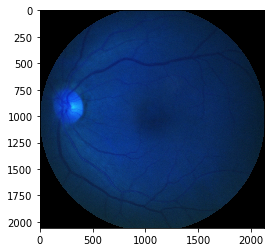

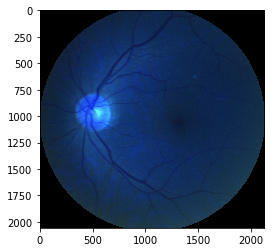

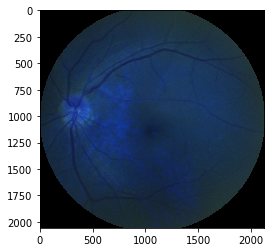

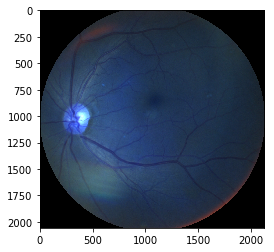

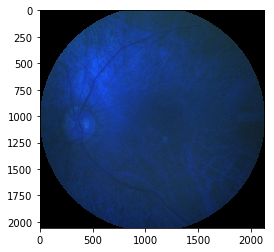

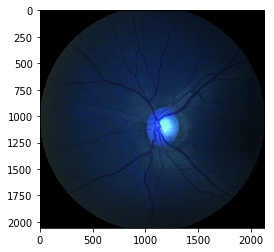

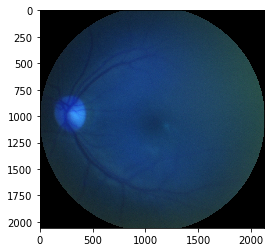

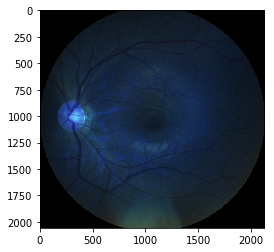

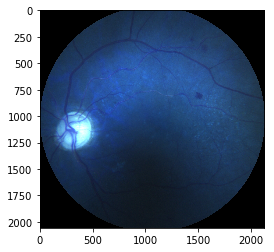

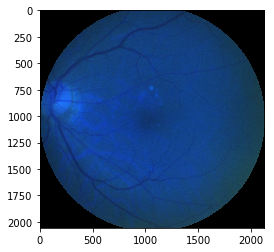



10 Best performing images:


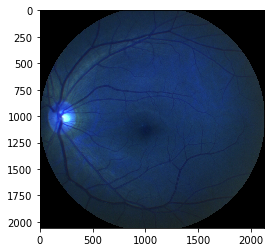

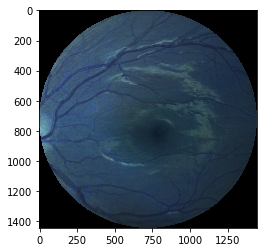

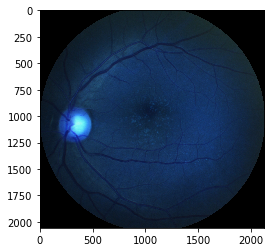

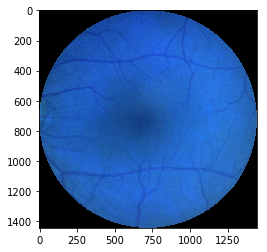

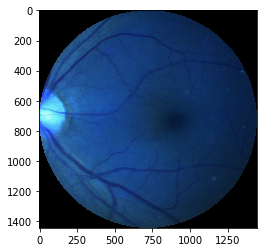

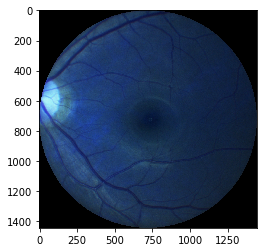

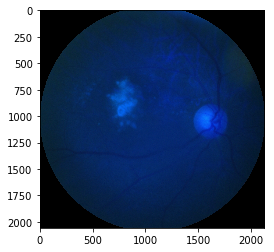

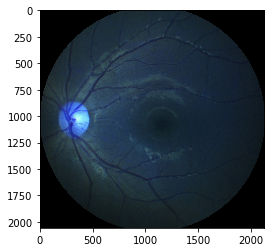

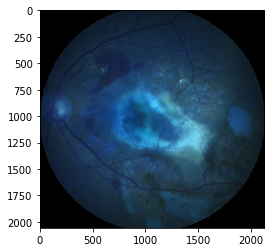

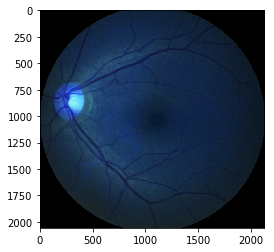

In [0]:
strengths_sorted_asc = sorted(image_class_strength, key=image_class_strength.__getitem__)
strengths_sorted_desc = sorted(image_class_strength, key=image_class_strength.__getitem__, reverse=True)

print("10 Worst performing images:")
i = 0
for key in strengths_sorted_desc:
  plt.imshow(images_test[key])
  plt.show()
  i+= 1
  if i > 9:
    break

print("\n\n10 Best performing images:")
i = 0
for key in strengths_sorted_asc:
  plt.imshow(images_test[key])
  plt.show()
  plt.show()
  i+= 1
  if i > 9:
    break

Graph the test accuracy scores and total time elaspsed of the various models

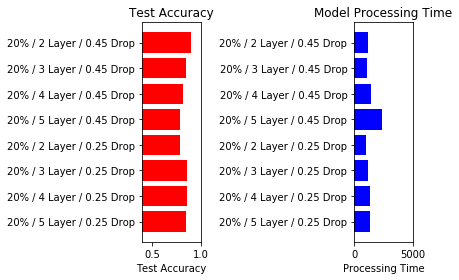

In [0]:
# Test Accuracy of all models
y_pos = np.arange(len(processing_time_list))
plt.subplot(1, 2, 1)
plt.barh(y_pos, [test_performance_list[i] for i in range(
    len(test_performance_list))], align='center', color='red')
plt.yticks(y_pos, ["20% / 5 Layer / 0.25 Drop", "20% / 4 Layer / 0.25 Drop",
                   "20% / 3 Layer / 0.25 Drop", "20% / 2 Layer / 0.25 Drop",
                   "20% / 5 Layer / 0.45 Drop", "20% / 4 Layer / 0.45 Drop",
                   "20% / 3 Layer / 0.45 Drop", "20% / 2 Layer / 0.45 Drop"])
plt.xlabel('Test Accuracy')
plt.title('Test Accuracy')
plt.xlim([0.4,1])
plt.tight_layout()


# Elapsed time of all models
plt.subplot(1, 2, 2)
plt.barh(y_pos, [processing_time_list[i] for i in range(
    len(processing_time_list))], align='center', color='blue')
plt.yticks(y_pos, ["20% / 5 Layer / 0.25 Drop", "20% / 4 Layer / 0.25 Drop",
                   "20% / 3 Layer / 0.25 Drop", "20% / 2 Layer / 0.25 Drop",
                   "20% / 5 Layer / 0.45 Drop", "20% / 4 Layer / 0.45 Drop",
                   "20% / 3 Layer / 0.45 Drop", "20% / 2 Layer / 0.45 Drop"])
plt.xlabel('Processing Time')
plt.title('Model Processing Time')
plt.xlim([0,5000])
plt.tight_layout()
plt.show()

* All models in this notebook used as input images that were scaled down to dimensions that were 20% of the average height and 20% of the average width of the original images.

* The best performing model in terms of accuracy was the two layer network with 45% dropout regulatization being used, achieving 90.5% on the test set.

* In general, the models using 25% dropout regularization performed beter than their counterparts with 45% dropout with the major exception of the best performing model noted above.

* In general, shallower models performed better than deeper ones, with one exception.

* In terms of processing time  shallower networks generally reached an optimal validation accuracy more quickly than deeper ones.

* The average performance of models with 25% dropout regularization is 84.3%.

* The average performance of models with 45% dropout regularization is 84.0%.